**Цель проекта:**  
Разработать алгоритм, который для товаров будет подбирать 5 наиболее похожих товаров из сформированной базы. Оценка качества производится по метрике accuracy@5  
**Входные данные:**
1. База товаров, каждый из которых представлен как уникальный id и вектор признаков размерностью 72  
2. Обучающий датасет - один товар, для которого известен уникальный id, вектор признаков и id товара, который максимально похож на него  
3. Тестовый датасет - датасет с товарами, для которых нужно найти наиболее близкие товары из базы  
4. Правильные ответы для тестового датасета

При решении использовалась библиотека FAISS(использовалась версия для обучения на GPU)

# Подготовка к работе

## Импорты

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import faiss
from statsmodels.stats.outliers_influence import variance_inflation_factor
from tqdm.notebook import tqdm
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler

In [3]:
import zipfile
import requests
from urllib.parse import urlencode


In [4]:
IS_LOCAL = True

## Загрузка датасета из yandex.drive на виртуальный диск Colab

In [5]:
if not IS_LOCAL:
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    public_key = 'https://disk.yandex.ru/d/BBEphK0EHSJ5Jw'

    final_url = base_url + urlencode(dict(public_key=public_key))
    response = requests.get(final_url)
    download_url = response.json()['href']

    download_response = requests.get(download_url)
    with open('data.zip', 'wb') as f:   # Здесь укажите нужный путь к файлу
        f.write(download_response.content)

    # Укажите путь к zip-архиву
    zip_path = '/content/data.zip'

    # Распаковка zip-архива
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall()
        
    root_data = '/content'
else:
    root_data = './data'

In [6]:
dict_base = {}
for i in range(72):
    dict_base[str(i)] = 'float32'
dict_base
dict_train = dict_base.copy()
dict_train['Target'] = 'str'

# Загрузка данных и первичный обзор данных

## base dataset

In [7]:
dict_base = {}
for i in range(72):
    dict_base[str(i)] = 'float32'
dict_base
dict_train = dict_base.copy()
dict_train['Target'] = 'str'

In [8]:
df_base = pd.read_csv(f'{root_data}/base.csv', index_col=0, dtype=dict_base)

In [9]:
df_base[['0', '1', '2']].info()
df_base.head()

<class 'pandas.core.frame.DataFrame'>
Index: 2918139 entries, 0-base to 4744766-base
Data columns (total 3 columns):
 #   Column  Dtype  
---  ------  -----  
 0   0       float32
 1   1       float32
 2   2       float32
dtypes: float32(3)
memory usage: 55.7+ MB


,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,
0-base,-115.083893,11.152912,-64.426758,-118.880890,216.482437,-104.698059,-469.070587,44.348083,120.915344,181.449707,...,-42.808693,38.800827,-151.762177,-74.389091,63.666340,-4.703861,92.933609,115.269188,-112.756638,-60.830353
1-base,-34.562202,13.332763,-69.787613,-166.533478,57.680607,-86.098373,-85.076668,-35.637436,119.718636,195.234192,...,-117.767525,41.099998,-157.829407,-94.446808,68.202110,24.346846,179.937927,116.834000,-84.888939,-59.524609
2-base,-54.233746,6.379371,-29.210136,-133.413834,150.895828,-99.435326,52.554794,62.381706,128.951447,164.381470,...,-76.397797,46.011803,-207.144424,127.325569,65.566177,66.325684,81.073486,116.594154,-1074.464844,-32.527206
3-base,-87.520126,4.037884,-87.803032,-185.067627,76.369537,-58.985165,-383.182831,-33.611237,122.031914,136.233582,...,-70.647942,-6.358921,-147.201050,-37.692749,66.202888,-20.566910,137.206940,117.474098,-1074.464844,-72.915489
4-base,-72.743851,6.522048,43.671265,-140.608032,5.820023,-112.074081,-397.711273,45.182499,122.167183,112.119064,...,-57.199104,56.642403,-159.351837,85.944725,66.766319,-2.505783,65.315285,135.051590,-1074.464844,0.319401


## train dataset

In [10]:
df_train = pd.read_csv(f'{root_data}/train.csv', index_col=0, dtype=dict_train)

In [11]:
df_train[['0', '1', '2', 'Target']].info()
df_train.head()

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 0-query to 99999-query
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       100000 non-null  float32
 1   1       100000 non-null  float32
 2   2       100000 non-null  float32
 3   Target  100000 non-null  object 
dtypes: float32(3), object(1)
memory usage: 2.7+ MB


,0,1,2,3,4,5,6,7,8,9,...,63,64,65,66,67,68,69,70,71,Target
Id,,,,,,,,,,,,,,,,,,,,,
0-query,-53.882748,17.971436,-42.117104,-183.936676,187.517487,-87.144928,-347.360596,38.307602,109.085564,30.413513,...,70.107361,-155.802567,-101.965942,65.903793,34.457500,62.642094,134.763596,-415.750244,-25.958572,675816-base
1-query,-87.776367,6.806268,-32.054546,-177.260391,120.803329,-83.810593,-94.572746,-78.433090,124.915901,140.331070,...,4.669178,-151.697708,-1.638704,68.170876,25.096191,89.974976,130.589630,-1035.092163,-51.276833,366656-base
2-query,-49.979565,3.841486,-116.118591,-180.401978,190.128433,-50.837620,26.943937,-30.447489,125.771164,211.607819,...,78.039764,-169.146194,82.144188,66.008217,18.400496,212.409729,121.931473,-1074.464844,-22.547178,1447819-base
3-query,-47.810562,9.086598,-115.401695,-121.011360,94.652840,-109.255409,-775.150146,79.186523,124.003098,242.650650,...,44.515266,-145.416748,93.990982,64.131348,106.061920,83.178757,118.277725,-1074.464844,-19.902788,1472602-base
4-query,-79.632126,14.442886,-58.903397,-147.052536,57.127068,-16.239529,-321.317963,45.984676,125.941284,103.392670,...,45.028912,-196.092072,-117.626335,66.926224,42.456169,77.621765,92.479927,-1074.464844,-21.149351,717819-base


##valid dataset

In [12]:
df_valid = pd.read_csv(f'{root_data}/validation.csv', index_col=0, dtype=dict_base)

In [13]:
df_valid[['0', '1', '2']].info()
df_valid.head()

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 100000-query to 199999-query
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       100000 non-null  float32
 1   1       100000 non-null  float32
 2   2       100000 non-null  float32
dtypes: float32(3)
memory usage: 1.9+ MB


,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,
100000-query,-57.372734,3.597752,-13.213642,-125.926788,110.745941,-81.279594,-461.003174,139.815720,112.880981,75.215752,...,-75.513023,52.830902,-143.439453,59.051933,69.282242,61.927513,111.592529,115.140656,-1099.130493,-117.079361
100001-query,-53.758705,12.790300,-43.268543,-134.417618,114.449913,-90.520126,-759.626038,63.995087,127.117905,53.128998,...,-79.441833,29.185436,-168.605896,-82.872444,70.765602,-65.975952,97.077164,123.391640,-744.442322,-25.009319
100002-query,-64.175095,-3.980927,-7.679249,-170.160934,96.446159,-62.377739,-759.626038,87.477554,131.270111,168.920319,...,-134.795410,37.368729,-159.662308,-119.232727,67.710442,86.002060,137.636414,141.081635,-294.052277,-70.969604
100003-query,-99.286858,16.123936,9.837166,-148.060440,83.697083,-133.729721,58.576405,-19.046659,115.042404,75.206734,...,-77.236107,44.100494,-132.530121,-106.318985,70.883957,23.577892,133.183960,143.252945,-799.363647,-89.392670
100004-query,-79.532921,-0.364173,-16.027431,-170.884949,165.453918,-28.291668,33.931934,34.411217,128.903976,102.086914,...,-123.770248,45.635944,-134.258926,13.735359,70.617630,15.332115,154.568115,101.700638,-1171.892334,-125.307892


In [14]:
df_valid_ans = pd.read_csv(f'{root_data}/validation_answer.csv', index_col=0)

In [15]:
df_valid_ans.info()
df_valid_ans.head()

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 100000-query to 199999-query
Data columns (total 1 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   Expected  100000 non-null  object
dtypes: object(1)
memory usage: 1.5+ MB


,Expected
Id,
100000-query,2676668-base
100001-query,91606-base
100002-query,472256-base
100003-query,3168654-base
100004-query,75484-base


# EDA

В файлах `train_eda.html` и `base_eda.html` представлен EDA датасета train и base. Из данного отчета можно сделать вывод, что в датасетах нет пропусков и дубликатов. Датасет train содержит 100000 строк. Датасет base содержит 2918139 строк. Также видно, что оба датасета имеют одинаковую структуру и распределение признаков. В датасетах все признаки, кроме '6', '21', '25', '33', '44', '59','63', '65', '70' распределены нормально

Дополнительно выведем описательную статистику датасетя train

In [16]:
df_train.describe().T.style.background_gradient(subset=['std'], cmap='Blues')

,count,mean,std,min,25%,50%,75%,max
0,100000.000000,-85.328667,25.803650,-186.280273,-103.309149,-85.273697,-67.330811,14.585236
1,100000.000000,7.664345,4.955601,-11.560507,4.313784,7.652854,10.981191,28.917845
2,100000.000000,-43.667046,39.110588,-224.896057,-69.494486,-42.830246,-17.713690,128.108459
3,100000.000000,-146.118637,20.434750,-223.307220,-160.028522,-146.067444,-132.277744,-60.751625
4,100000.000000,111.770592,47.700665,-93.272018,79.474319,112.260101,143.760826,301.363586
5,100000.000000,-73.178787,28.718643,-184.962448,-92.834080,-73.364422,-53.699613,51.849709
6,100000.000000,-440.615112,279.047058,-791.469482,-738.536865,-511.837753,-201.116577,109.625191
7,100000.000000,21.231590,65.984711,-278.582825,-22.131763,22.278989,65.899597,288.171844
8,100000.000000,123.067879,6.492044,94.831146,118.674643,123.087540,127.541805,149.356201
9,100000.000000,126.120201,64.912010,-142.156952,82.545027,125.963341,169.701004,392.827148


Можно заметить, что некоторые признаки имеют большое стандартное отклонение, что можен влиять на качество обучения  
Посмотрим также на корреляцию Пирсона и Спирмена

Text(0.5, 1.0, 'Корреляция Пирсона')

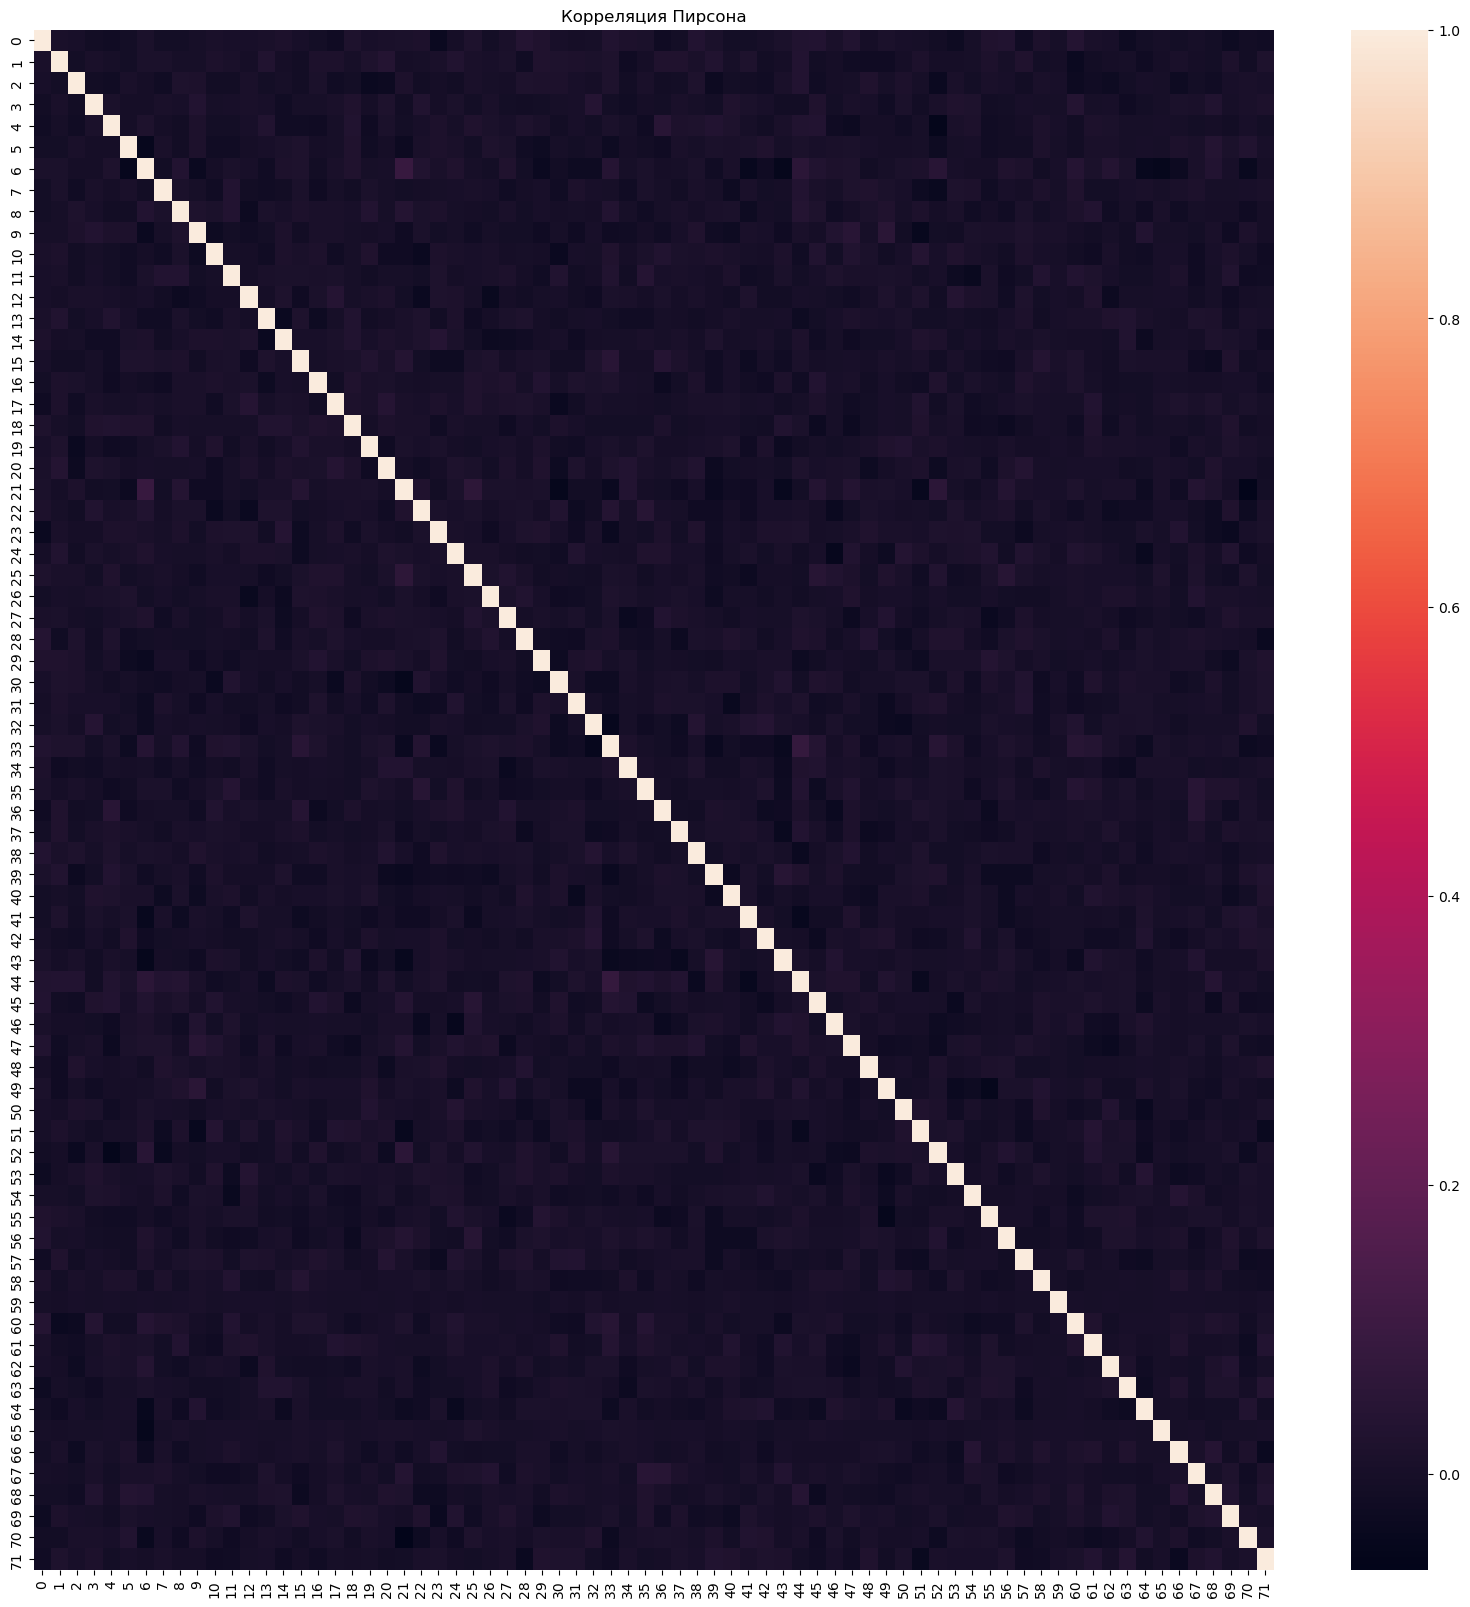

In [17]:
_, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(df_train.drop('Target', axis=1).corr(), ax=ax).set_title('Корреляция Пирсона')

Text(0.5, 1.0, 'Корреляция Спирмена')

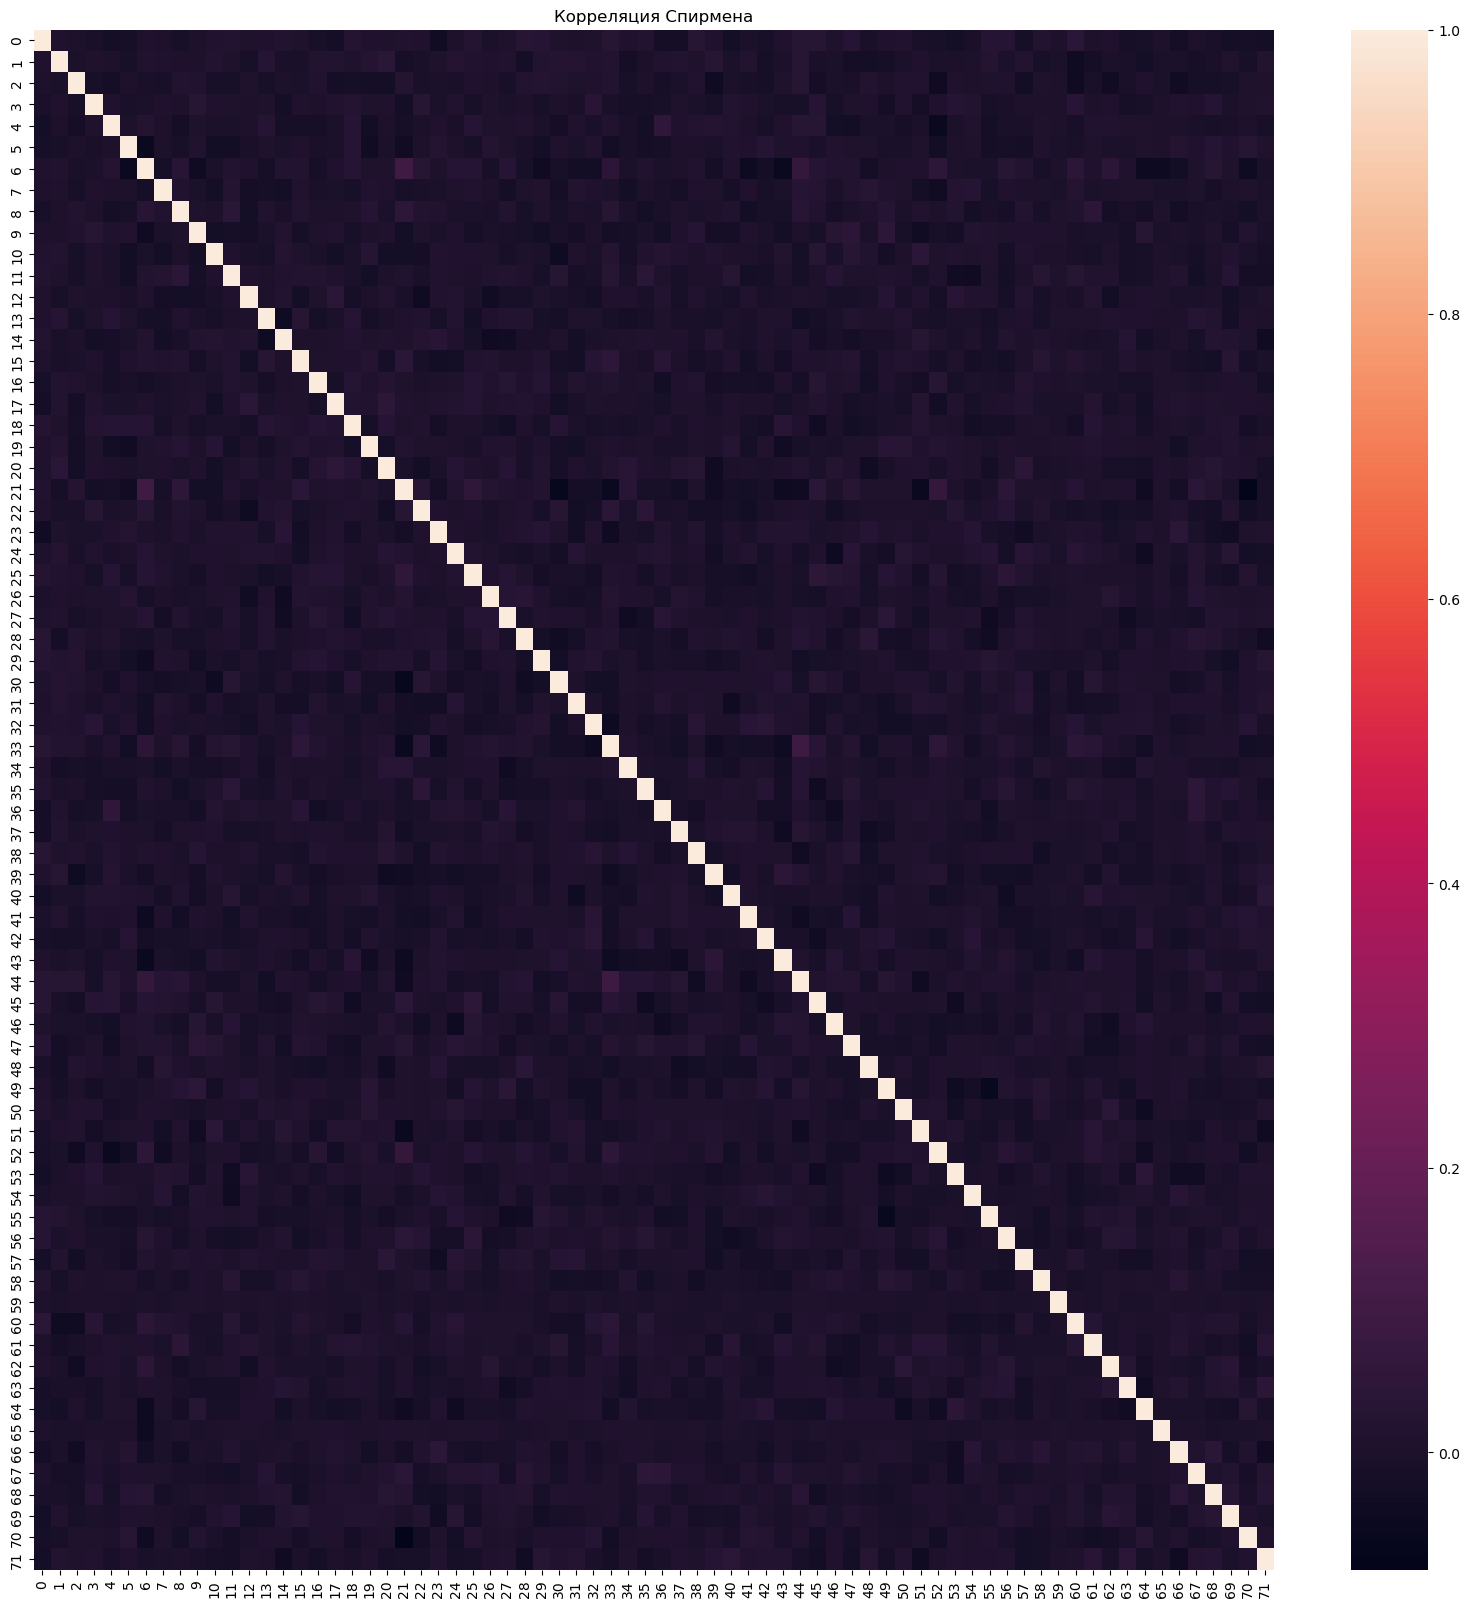

In [18]:
_, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(df_train.drop('Target', axis=1).corr(method='spearman'), ax=ax).set_title('Корреляция Спирмена')

Можно заметить, что линейных зависимостей между признаками нет

# Baseline models

Из библиотеки Faise рассмотрим модели FlatL2, IVF, HNSW. Чтобы не очень долго не ждать вычислений, эксперименты будем проводить на выборке из 50000 экземпляров из датасета base

In [19]:
df_samples = df_base[:50000]
df_samples_np = np.ascontiguousarray(df_samples.values)

df_base_np = np.ascontiguousarray(df_base.values)

features_train = df_train.drop('Target', axis=1)
target_train = df_train['Target']
features_train_np = np.ascontiguousarray(features_train.values)

features_valid = df_valid.copy()
target_valid = df_valid_ans.copy()
features_valid_np = np.ascontiguousarray(features_valid.values)

In [20]:
dims = df_base_np.shape[1]
k_nearest = 5
base_index = {k: v for k, v in enumerate(df_base.index.to_list())}
gpu = [faiss.StandardGpuResources()]

In [21]:
def accuracy5(targets, predicted, base_index):
  acc = 0
  for target, el in zip(targets.tolist(), predicted.tolist()):
    acc += int(target in [base_index[r] for r in el])
  return acc / len(predicted)

## Модель FlatL2 (полный перебор)

In [22]:
idx_flatL2 = faiss.IndexFlatL2(dims)
idx_flatL2_gpu = faiss.index_cpu_to_gpu_multiple_py(gpu, idx_flatL2)
idx_flatL2_gpu.add(df_base_np)

In [23]:
%%time
vecs, idx = idx_flatL2_gpu.search(features_train_np, k_nearest)

CPU times: total: 8.06 s
Wall time: 11.5 s


In [24]:
accuracy_flatL2 = accuracy5(target_train.values, idx, base_index)
print(f'Для модели FlatL2 accuracy@5 = {accuracy_flatL2:.2%}')

Для модели FlatL2 accuracy@5 = 13.80%


## Модель IVF

In [25]:
n_quantizer = 20 # Выбрано экспериментальным путем: баланс между скоростью и качеством
quantizer = faiss.IndexFlatL2(dims)
idx_ivf_l2 = faiss.IndexIVFFlat(quantizer, dims, n_quantizer)
idx_ivf_l2_gpu = faiss.index_cpu_to_gpu_multiple_py(gpu, idx_ivf_l2)
idx_ivf_l2_gpu.train(df_base_np)
idx_ivf_l2_gpu.add(df_base_np)

In [26]:
%%time
idx_ivf_l2_gpu.nprobe = 1 # в какой количество кластеров заходить при поиске
vecs, idx = idx_ivf_l2_gpu.search(features_train_np, k_nearest)

CPU times: total: 14.4 s
Wall time: 14.4 s


In [27]:
accuracy_ivf = accuracy5(target_train.values, idx, base_index)
print(f'Для модели IVF accuracy@5 = {accuracy_ivf:.2%}')

Для модели IVF accuracy@5 = 11.26%


In [28]:
%%time
idx_ivf_l2_gpu.nprobe = 10 # в какой количество кластеров заходить при поиске
vecs, idx = idx_ivf_l2_gpu.search(features_train_np, k_nearest)

CPU times: total: 2min 13s
Wall time: 2min 13s


In [29]:
accuracy_ivf = accuracy5(target_train.values, idx, base_index)
print(f'Для модели IVF accuracy@5 = {accuracy_ivf:.2%}')

Для модели IVF accuracy@5 = 13.80%


## Модель HNSW

In [30]:
idx_hnsw = faiss.IndexHNSWFlat(dims, 128)
idx_hnsw_gpu = faiss.index_cpu_to_gpu_multiple_py(gpu, idx_hnsw)
idx_hnsw_gpu.add(df_base_np)

In [31]:
%%time
vecs, idx = idx_hnsw_gpu.search(features_train_np, k_nearest)

CPU times: total: 30.6 s
Wall time: 1.75 s


In [32]:
accuracy_hnsw = accuracy5(target_train.values, idx, base_index)
print(f'Для модели HNSW accuracy@5 = {accuracy_hnsw:.2%}')

Для модели HNSW accuracy@5 = 11.73%


## Вывод
Было проверено 3 модели: FlatL2, IVF, HNSW  
Были получены следующие метрики:  
* Для FlatL2 `accuracy@5 = 11.72%`  
* Для IVF c 20 кластерами и поиском по 10 кластерам `accuracy@5 = 13.80%`  
* Для HNSW `accuracy@5 = 11.72%`  
  
Модель HNSW уступает двум другим, поэтому дальше не будем ее использовать. Для модели FlatL2 и IVF удалось получить одинаковые метрики. Однако по непонятной причине поиск в модели IVF происходит дольше чем в FlatL2, хотя в теории IVF должен быть быстрее

# Эксперименты/улучшение результатов

## Предобработка данных

### Устранение мультиколлениарности

In [33]:
df_vif = pd.DataFrame()
df_vif['feature'] = df_base.columns

df_vif['vif'] = [variance_inflation_factor(df_base.values, i) for i in range(len(df_base.columns))]
  
df_vif.sort_values(by='vif', ascending=False)

c:\Users\hasanov\AppData\Local\anaconda3\envs\faiss\Lib\site-packages\numpy\linalg\linalg.py:1694: RuntimeWarning: overflow encountered in cast
  s = s.astype(_realType(result_t), copy=False)


,feature,vif
3,3,56.608867
0,0,13.383351
1,1,3.886742
2,2,2.406508
63,63,1.223082
...,...,...
8,8,1.003244
65,65,1.001878
59,59,0.999877
66,66,0.950510


Сейчас в датасете нет мультиколлениарности

## Отбор признаков

Оставим в датасете только признаки, которые имеют нормальное распределение.  
Из EDA видно, что признаки '6', '21', '25', '33', '44', '59','63', '65', '70' не распределены нормально. Удалим их

In [34]:
df_base_norm = df_base.drop(['6', '21', '25', '33', '44', '59','63', '65', '70'], axis=1)
df_train_norm = df_train.drop(['6', '21', '25', '33', '44', '59','63', '65', '70'], axis=1)

In [35]:
df_base_norm_np = np.ascontiguousarray(df_base_norm.values)

features_train = df_train_norm.drop('Target', axis=1)
target_train = df_train_norm['Target']
features_train_norm_np = np.ascontiguousarray(features_train.values)

dims_norm = df_base_norm_np.shape[1]

### Модель FlatL2 (полный перебор)

In [36]:
idx_flatL2 = faiss.IndexFlatL2(dims_norm)
idx_flatL2_gpu = faiss.index_cpu_to_gpu_multiple_py(gpu, idx_flatL2)
idx_flatL2_gpu.add(df_base_norm_np)

In [37]:
%%time
vecs, idx = idx_flatL2_gpu.search(features_train_norm_np, k_nearest)

CPU times: total: 7.56 s
Wall time: 10.9 s


In [38]:
accuracy_flatL2 = accuracy5(target_train.values, idx, base_index)
print(f'Для модели FlatL2 accuracy@5 = {accuracy_flatL2:.2%}')

Для модели FlatL2 accuracy@5 = 69.62%


### Модель IVF

In [39]:
n_quantizer = 20 # Выбрано экспериментальным путем: баланс между скоростью и качеством
quantizer = faiss.IndexFlatL2(dims_norm)
idx_ivf_l2 = faiss.IndexIVFFlat(quantizer, dims_norm, n_quantizer)
idx_ivf_l2_gpu = faiss.index_cpu_to_gpu_multiple_py(gpu, idx_ivf_l2)
idx_ivf_l2_gpu.train(df_base_norm_np)
idx_ivf_l2_gpu.add(df_base_norm_np)

In [40]:
%%time
idx_ivf_l2_gpu.nprobe = 10 # в какой количество кластеров заходить при поиске
vecs, idx = idx_ivf_l2_gpu.search(features_train_norm_np, k_nearest)

CPU times: total: 1min 54s
Wall time: 1min 54s


In [41]:
accuracy_ivf = accuracy5(target_train.values, idx, base_index)
print(f'Для модели IVF accuracy@5 = {accuracy_ivf:.2%}')

Для модели IVF accuracy@5 = 69.53%


После удаления не нормально распределенных признаков метрика выросла:
* До `accuracy@5 = 69.62%` для Flat2L  
* До `accuracy@5 = 69.53%` для IVF  
  
Оставляем данное изменение.
Проверим на мультиколлениарность текущие признаки

In [42]:
df_vif_norm = pd.DataFrame()
df_vif_norm['feature'] = df_base_norm.columns

df_vif_norm['vif'] = [variance_inflation_factor(df_base_norm.values, i) for i in range(len(df_base_norm.columns))]

In [43]:
df_vif_norm.sort_values(by='vif', ascending=False).head()

,feature,vif
18,19,2762.389251
58,66,1312.926609
7,8,378.992560
49,54,346.062707
51,56,297.745815


После удаления части признаков появилась мультиколлениарность. Удалим все признаки, у которых vif >= 10

In [44]:
drop_features = df_vif_norm.query('vif >= 10')['feature']

In [45]:
df_base_norm_vif = df_base_norm.drop(drop_features.values, axis=1)
df_train_norm_vif = df_train_norm.drop(drop_features.values, axis=1)

In [46]:
df_base_norm_vif_np = np.ascontiguousarray(df_base_norm_vif.values)

features_train = df_train_norm_vif.drop('Target', axis=1)
target_train = df_train_norm['Target']
features_train_norm_vif_np = np.ascontiguousarray(features_train.values)

dims_norm_vif = df_base_norm_vif_np.shape[1]

### Модель FlatL2 (полный перебор)

In [47]:
idx_flatL2 = faiss.IndexFlatL2(dims_norm_vif)
idx_flatL2_gpu = faiss.index_cpu_to_gpu_multiple_py(gpu, idx_flatL2)
idx_flatL2_gpu.add(df_base_norm_vif_np)

In [48]:
%%time
vecs, idx = idx_flatL2_gpu.search(features_train_norm_vif_np, k_nearest)

CPU times: total: 7.25 s
Wall time: 10.4 s


In [49]:
accuracy_flatL2 = accuracy5(target_train.values, idx, base_index)
print(f'Для модели FlatL2 accuracy@5 = {accuracy_flatL2:.2%}')

Для модели FlatL2 accuracy@5 = 68.66%


### Модель IVF

In [50]:
n_quantizer = 20 # Выбрано экспериментальным путем: баланс между скоростью и качеством
quantizer = faiss.IndexFlatL2(dims_norm_vif)
idx_ivf_l2 = faiss.IndexIVFFlat(quantizer, dims_norm_vif, n_quantizer)
idx_ivf_l2_gpu = faiss.index_cpu_to_gpu_multiple_py(gpu, idx_ivf_l2)
idx_ivf_l2_gpu.train(df_base_norm_vif_np)
idx_ivf_l2_gpu.add(df_base_norm_vif_np)

In [51]:
%%time
idx_ivf_l2_gpu.nprobe = 10 # в какой количество кластеров заходить при поиске
vecs, idx = idx_ivf_l2_gpu.search(features_train_norm_vif_np, k_nearest)

CPU times: total: 1min 13s
Wall time: 1min 13s


In [52]:
accuracy_ivf = accuracy5(target_train.values, idx, base_index)
print(f'Для модели IVF accuracy@5 = {accuracy_ivf:.2%}')

Для модели IVF accuracy@5 = 68.62%


Качество обеих моделей упали:
* До `accuracy@5 = 68.66%` для Flat2L  
* До `accuracy@5 = 68.62%` для IVF  

Следовательно, устранение мультиколлениарности ухудшает качество модели. Не будем использовать данное преобразование

## Нормализация данных

### RobustScaler

In [53]:
features_train = df_train_norm.drop('Target', axis=1)
target_train = df_train_norm['Target']

scaler = RobustScaler()
df_base_robust = scaler.fit_transform(df_base_norm)
features_train_robust = scaler.transform(features_train)

df_base_robust_np = np.ascontiguousarray(df_base_robust)
features_train_robust_np = np.ascontiguousarray(features_train_robust)

dims_norm = df_base_norm.shape[1]

c:\Users\hasanov\AppData\Local\anaconda3\envs\faiss\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\hasanov\AppData\Local\anaconda3\envs\faiss\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\hasanov\AppData\Local\anaconda3\envs\faiss\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\hasanov\AppData\Local\anaconda3\envs\faiss\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse i

#### Модель FlatL2 (полный перебор)

In [54]:
idx_flatL2 = faiss.IndexFlatL2(dims_norm)
idx_flatL2_gpu = faiss.index_cpu_to_gpu_multiple_py(gpu, idx_flatL2)
idx_flatL2_gpu.add(df_base_robust_np)

In [55]:
%%time
vecs, idx = idx_flatL2_gpu.search(features_train_robust_np, k_nearest)

CPU times: total: 7.64 s
Wall time: 11 s


In [56]:
accuracy_flatL2 = accuracy5(target_train.values, idx, base_index)
print(f'Для модели FlatL2 accuracy@5 = {accuracy_flatL2:.2%}')

Для модели FlatL2 accuracy@5 = 71.05%


#### Модель IVF

In [57]:
n_quantizer = 20 # Выбрано экспериментальным путем: баланс между скоростью и качеством
quantizer = faiss.IndexFlatL2(dims_norm)
idx_ivf_l2 = faiss.IndexIVFFlat(quantizer, dims_norm, n_quantizer)
idx_ivf_l2_gpu = faiss.index_cpu_to_gpu_multiple_py(gpu, idx_ivf_l2)
idx_ivf_l2_gpu.train(df_base_robust_np)
idx_ivf_l2_gpu.add(df_base_robust_np)

In [58]:
%%time
idx_ivf_l2_gpu.nprobe = 10 # в какой количество кластеров заходить при поиске
vecs, idx = idx_ivf_l2_gpu.search(features_train_robust_np, k_nearest)

CPU times: total: 2min 4s
Wall time: 2min 4s


In [59]:
accuracy_ivf = accuracy5(target_train.values, idx, base_index)
print(f'Для модели IVF accuracy@5 = {accuracy_ivf:.2%}')

Для модели IVF accuracy@5 = 70.91%


После после добавления RobustScaler метрика выросла:
* До `accuracy@5 = 71.05%` для Flat2L  
* До `accuracy@5 = 70.91%` для IVF  
  
Оставляем данное изменение.
В ходе всех экспериментов модель IVF показывала результаты хуже, чем модель Flat2L. Поэтому все дальнейшие эксперименты будем проводить на модели Flat2L

### StandardScaler

In [62]:
features_train = df_train_norm.drop('Target', axis=1)
target_train = df_train_norm['Target']

scaler = StandardScaler()
df_base_standart = scaler.fit_transform(df_base_norm)
features_train_standart = scaler.transform(features_train)

df_base_standart_np = np.ascontiguousarray(df_base_standart)
features_train_standart_np = np.ascontiguousarray(features_train_standart)

dims_norm = df_base_norm.shape[1]

c:\Users\hasanov\AppData\Local\anaconda3\envs\faiss\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\hasanov\AppData\Local\anaconda3\envs\faiss\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\hasanov\AppData\Local\anaconda3\envs\faiss\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\hasanov\AppData\Local\anaconda3\envs\faiss\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse i

#### Модель FlatL2 (полный перебор)

In [63]:
idx_flatL2 = faiss.IndexFlatL2(dims_norm)
idx_flatL2_gpu = faiss.index_cpu_to_gpu_multiple_py(gpu, idx_flatL2)
idx_flatL2_gpu.add(df_base_standart_np)

In [64]:
%%time
vecs, idx = idx_flatL2_gpu.search(features_train_standart_np, k_nearest)

CPU times: total: 7.56 s
Wall time: 10.8 s


In [65]:
accuracy_flatL2 = accuracy5(target_train.values, idx, base_index)
print(f'Для модели FlatL2 accuracy@5 = {accuracy_flatL2:.2%}')

Для модели FlatL2 accuracy@5 = 71.05%


StandardScaler показывает такие же результаты, как и RobustScaler

### MinMaxScaler

In [66]:
features_train = df_train_norm.drop('Target', axis=1)
target_train = df_train_norm['Target']

scaler = MinMaxScaler()
df_base_minmax = scaler.fit_transform(df_base_norm)
features_train_minmax = scaler.transform(features_train)

df_base_minmax_np = np.ascontiguousarray(df_base_minmax)
features_train_minmax_np = np.ascontiguousarray(features_train_minmax)

dims_norm = df_base_norm.shape[1]

c:\Users\hasanov\AppData\Local\anaconda3\envs\faiss\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\hasanov\AppData\Local\anaconda3\envs\faiss\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\hasanov\AppData\Local\anaconda3\envs\faiss\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\hasanov\AppData\Local\anaconda3\envs\faiss\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse i

#### Модель FlatL2 (полный перебор)

In [67]:
idx_flatL2 = faiss.IndexFlatL2(dims_norm)
idx_flatL2_gpu = faiss.index_cpu_to_gpu_multiple_py(gpu, idx_flatL2)
idx_flatL2_gpu.add(df_base_minmax_np)

In [68]:
%%time
vecs, idx = idx_flatL2_gpu.search(features_train_minmax_np, k_nearest)

CPU times: total: 7.56 s
Wall time: 10.8 s


In [69]:
accuracy_flatL2 = accuracy5(target_train.values, idx, base_index)
print(f'Для модели FlatL2 accuracy@5 = {accuracy_flatL2:.2%}')

Для модели FlatL2 accuracy@5 = 71.02%


При использование MinMaxScaler метрика упала - `accuracy@5 = 71.02%`  
В итоговой предобработке данных будем использовать RobustScaler

## Использование разных метрик расстояния

Во всех моделях до этого использовалось Евклидово расстояние. Попробуем другие метрики расстояния

In [70]:
features_train = df_train_norm.drop('Target', axis=1)
target_train = df_train_norm['Target']

scaler = RobustScaler()
df_base_robust = scaler.fit_transform(df_base_norm)
features_train_robust = scaler.transform(features_train)

df_base_robust_np = np.ascontiguousarray(df_base_robust)
features_train_robust_np = np.ascontiguousarray(features_train_robust)

dims_norm = df_base_norm.shape[1]

c:\Users\hasanov\AppData\Local\anaconda3\envs\faiss\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\hasanov\AppData\Local\anaconda3\envs\faiss\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\hasanov\AppData\Local\anaconda3\envs\faiss\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\hasanov\AppData\Local\anaconda3\envs\faiss\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse i

### Манхетоновское

In [71]:
idx_flatL1 = faiss.IndexFlat(dims_norm, faiss.METRIC_L1)
idx_flatL1_gpu = faiss.index_cpu_to_gpu_multiple_py(gpu, idx_flatL1)
idx_flatL1_gpu.add(df_base_robust_np)

In [72]:
%%time
vecs, idx = idx_flatL1_gpu.search(features_train_robust_np, k_nearest)

CPU times: total: 59.5 s
Wall time: 59.4 s


In [73]:
accuracy_flatL1 = accuracy5(target_train.values, idx, base_index)
print(f'Для модели Flat(расстояние L1) accuracy@5 = {accuracy_flatL1:.2%}')

Для модели Flat(расстояние L1) accuracy@5 = 70.70%


В результате замены Евклидова расстояния на Манхетоновское расстояние метрика упала до `accuracy@5 = 70.70%` 

### Максимальное скалярное произведение

In [74]:
idx_flatIP = faiss.IndexFlatIP(dims_norm)
idx_flatIP_gpu = faiss.index_cpu_to_gpu_multiple_py(gpu, idx_flatIP)
idx_flatIP_gpu.add(df_base_robust_np)

In [75]:
%%time
vecs, idx = idx_flatIP_gpu.search(features_train_robust_np, k_nearest)

CPU times: total: 10.8 s
Wall time: 10.7 s


In [76]:
accuracy_flatIP = accuracy5(target_train.values, idx, base_index)
print(f'Для модели Flat(расстояние IP) accuracy@5 = {accuracy_flatIP:.2%}')

Для модели Flat(расстояние IP) accuracy@5 = 66.98%


В результате замены Евклидова расстояния на Максимальное скалярное произведение метрика упала до `accuracy@5 = 66.98%` 

### Вывод

Таким образом, лучшая метрика достигается с помощью Евклидова расстояния

# Конструирование финальной модели

Таким образом, лучшей является модель:
* Flat  
* В качестве расстояние используем Евклидово расстояние   
* Удаляем признаки, которые распределены не нормально  
* Применяем RobustScaler

In [77]:
df_valid_norm = df_valid[df_base_norm.columns]

In [80]:
features_valid = df_valid_norm.copy()
target_valid = df_valid_ans['Expected']

scaler = RobustScaler()
df_base_robust = scaler.fit_transform(df_base_norm)
features_valid_robust = scaler.transform(features_valid)

df_base_robust_np = np.ascontiguousarray(df_base_robust)
features_valid_robust_np = np.ascontiguousarray(features_valid_robust)

dims_norm = df_base_norm.shape[1]

c:\Users\hasanov\AppData\Local\anaconda3\envs\faiss\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\hasanov\AppData\Local\anaconda3\envs\faiss\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\hasanov\AppData\Local\anaconda3\envs\faiss\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\hasanov\AppData\Local\anaconda3\envs\faiss\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse i

In [81]:
idx_final_model = faiss.IndexFlatL2(dims_norm)
idx_final_model_gpu = faiss.index_cpu_to_gpu_multiple_py(gpu, idx_final_model)
idx_final_model_gpu.add(df_base_robust_np)

In [82]:
%%time
vecs, idx = idx_final_model_gpu.search(features_valid_robust_np, k_nearest)

CPU times: total: 7.58 s
Wall time: 10.9 s


In [83]:
accuracy_final = accuracy5(target_valid.values, idx, base_index)
print(f'Для модели финальной модели на тестовой выборке accuracy@5 = {accuracy_final:.2%}')

Для модели финальной модели на тестовой выборке accuracy@5 = 70.94%


# Вывод

В ходе работы была решина задача метчинга. Для решения использовалась библиотека Faiss. Из библиотеки использовались модели: `Flat`, `IVF`, `HNSW`. Сразу была отсеена модель `HNSW` по причине того, что показывала результаты хуже. Модели `Flat`, `IVF` были изучены дополнительно:  
* Пробовал удалять признаки, которые не распределены нормально  
* Пробовал избавляться от мультиколлениарности  
* Пробовал преобразовывать признаки с помощью RobustScaler, StandardScaler, MinMaxScaler  
* Пробовал различные метрики расстояния: Евклидово, Манхетоновское, максимальное скалярное произведение  

В итоге лучшая модель была получена с помощью:
1. Использовать модель `Flat`
2. Удалить все признаки, которые не распределены нормально  
3. К числовым признакам применить RobustScaler  
4. В качесве расстояния использовать Евклидово расстояние  

У такой модели метрика равна:  
1. На тренировочной выборке `accuracy@5 = 71.05%`.  
2. На тестовой выборке `accuracy@5 = 70.94%`